In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# define key directories
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import illustris_python as il
from Corrfunc.theory.wp import wp
import sys
sys.path.insert(0, work)
from corrfunc_ls import compute_3D_ls

### functions

In [4]:
def generate_random_set(data, nx=3):
    x, y, z = data.T
    n = len(data)
    # generate a random set: Poisson-distributed points throughout the volume, but 3x more particles
    rand_set = np.random.uniform(round(min(x)), round(max(x)), size=(3*n,3))
    # convert to float32 (otherwise Corrfunc throws an error)
    rand_set = np.float32(rand_set)
    return rand_set

In [5]:
def get_subsample(data, nx=100):
    # random subsample to start: one thousandth of all the particles
    n = len(data)//nx
    print(f"drawing {n} random particles...")
    idx = np.random.choice(len(data), size=n, replace=False)  # get random indices
    return data[idx]

### load Illustris data

Snapshot 67 corresponds to redshift $z\sim 0.5$.

Get a 3D box with only dark matter particles:

In [6]:
# define output directory
basepath = '/scratch/08811/aew492/Illustris-3/output'
# load in dark matter particle coordinates
dm_pos = il.snapshot.loadSubset(basepath, 67, 'dm', ['Coordinates'])
# convert from kpc -> Mpc
dm_pos /= 1000

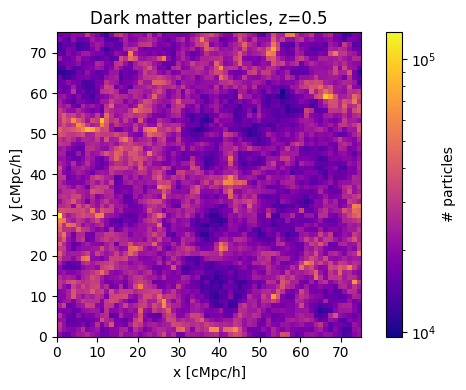

In [7]:
fig, ax = plt.subplots(figsize=(5.5,4))
_, _, _, im = ax.hist2d(dm_pos[:,0], dm_pos[:,1], cmap='plasma', norm=mpl.colors.LogNorm(), bins=64)
ax.set_xlim([0,75])
ax.set_ylim([0,75])
ticks = np.linspace(0, 70, 8)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_aspect('equal')
ax.set_xlabel('x [cMpc/h]')
ax.set_ylabel('y [cMpc/h]')
fig.colorbar(im, ax=ax, label='# particles')
ax.set_title('Dark matter particles, z=0.5')
fig.tight_layout()

### compute angular (2D) autocorrelation function

In [8]:
# subsample 1/100th
dm_subsample = get_subsample(dm_pos, nx=100)

drawing 941963 random particles...


In [10]:
# parameters for Corrfunc
x, y, z = dm_subsample.T
boxsize = float(round(max(x)))
nthreads = 12
pimax = 20.0  # distance to integrate along line of sight
rmin = 1.
rmax = 20.
nbins = 20
rbins = np.linspace(rmin, rmax, nbins+1)

A bit about `Corrfunc.theory.wp`:

Corrfunc can directly compute the projected auto-correlation function, $\omega_p(r_p)$.
This calculation sets periodic boundary conditions.
Randoms are calculated analytically based on the supplied boxsize.
The projected separation, $r_p$, is calculated in the X-Y plane while the line-of-sight separation, $\pi$, is calculated in the Z plane.
Only pairs with $\pi$ separation less than $\pi_\mathrm{max}$ are counted.

In [11]:
results_wp = wp(boxsize, pimax, nthreads, rbins, x, y, z)

In [12]:
results_wp.shape

(20,)

In [13]:
ravg = [(rbins[i+1]+rbins[i])/2 for i in range(nbins)]

Text(0.5, 1.0, '2D projected autocorrelation: DM particles')

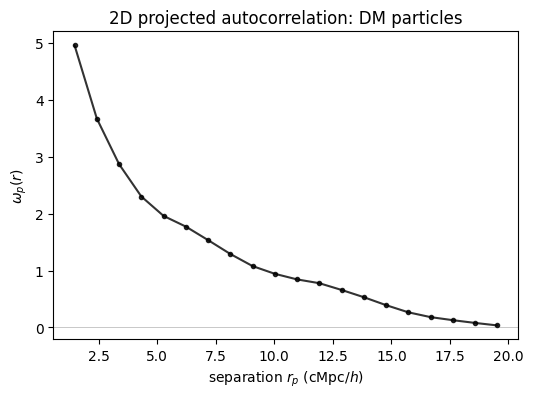

In [17]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(ravg, results_wp['wp'], color='k', marker='.', alpha=0.8)

ax.axhline(0, color='k', lw=0.5, alpha=0.3)
ax.set_xlabel(r'separation $r_p$ (cMpc/$h$)')
ax.set_ylabel(r'$\omega_p (r)$')
ax.set_title(r'2D projected autocorrelation: DM particles')